<b>Description:</b> Generate an optimized portfolio of equities in a playground environment given sample NASDAQ data. 

Credit here goes to Aghan Hussain

In [2]:
## Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
from datetime import datetime

# API key: 8b9yt7Fa2LUNy3s8QTjN
quandl.ApiConfig.api_key = '8b9yt7Fa2LUNy3s8QTjN'

In [114]:
start_date = datetime(2015,6,1)
end_date = datetime(2018,4,1) # End of WIKI's data updates
equities = ['NVDA', 'AAPL', 'AMZN', 'MSFT', 'BAC']
data = quandl.get_table('WIKI/PRICES', ticker = equities,
                        qopts = {'columns': ['date', 'ticker', 'adj_close']},
                        date = {'gte': start_date, 'lte': end_date},
                        paginate = True)


In [115]:
data

,date,ticker,adj_close
None,,,
0,2018-03-27,NVDA,225.520000
1,2018-03-26,NVDA,244.480000
2,2018-03-23,NVDA,232.970000
3,2018-03-22,NVDA,241.850000
4,2018-03-21,NVDA,248.560000
...,...,...,...
3548,2015-06-05,AAPL,123.206325
3549,2015-06-04,AAPL,123.886282
3550,2015-06-03,AAPL,124.614123


In [116]:
data.ticker.value_counts()

NVDA    711
MSFT    711
BAC     711
AMZN    710
AAPL    710
Name: ticker, dtype: int64

In [117]:
# Reorganize the data to set the date column as the row indices + set each ticker as a column
clean_data = data.set_index('date').pivot(columns='ticker')
clean_data

adj_close                                           
ticker            AAPL     AMZN        BAC       MSFT        NVDA
date                                                             
2015-06-01  125.011563   430.92  15.972996  44.378673   21.924698
2015-06-02  124.460894   430.99  16.137070  44.087388   21.488752
2015-06-03  124.614123   436.59  16.388005  44.021614   21.258532
2015-06-04  123.886282   430.78  16.242807  43.561196   21.640598
2015-06-05  123.206325   426.95  16.639681  43.354478   21.807140
...                ...      ...        ...        ...         ...
2018-03-21  171.270000  1581.86  31.870000  92.480000  248.560000
2018-03-22  168.845000  1544.10  30.550000  89.790000  241.850000
2018-03-23  164.940000  1495.56  29.170000  87.180000  232.970000
2018-03-26  172.770000  1555.86  30.440000  93.780000  244.480000
2018-03-27  168.340000  1497.05  29.520000  89.470000  225.520000

[711 rows x 5 columns]

In [118]:
# Calculate EoD returns 
EoD_returns = clean_data.pct_change()
EoD_returns

adj_close                                        
ticker          AAPL      AMZN       BAC      MSFT      NVDA
date                                                        
2015-06-01       NaN       NaN       NaN       NaN       NaN
2015-06-02 -0.004405  0.000162  0.010272 -0.006564 -0.019884
2015-06-03  0.001231  0.012993  0.015550 -0.001492 -0.010713
2015-06-04 -0.005841 -0.013308 -0.008860 -0.010459  0.017972
2015-06-05 -0.005489 -0.008891  0.024434 -0.004745  0.007696
...              ...       ...       ...       ...       ...
2018-03-21 -0.022655 -0.002931 -0.003440 -0.006979 -0.004087
2018-03-22 -0.014159 -0.023871 -0.041418 -0.029087 -0.026995
2018-03-23 -0.023128 -0.031436 -0.045172 -0.029068 -0.036717
2018-03-26  0.047472  0.040319  0.043538  0.075705  0.049406
2018-03-27 -0.025641 -0.037799 -0.030223 -0.045959 -0.077552

[711 rows x 5 columns]

In [119]:
# Calculate annual returns
annual_returns = EoD_returns.mean() * 250 # for all days where markets are open
annual_returns

           ticker
adj_close  AAPL      0.130878
           AMZN      0.475306
           BAC       0.253654
           MSFT      0.271179
           NVDA      0.908281
dtype: float64

In [120]:
# Calculate daily and annual covariance to assess risk
daily_cov = EoD_returns.cov()
annual_cov = daily_cov * 250

Let's begin to analyze our portfolio in terms of risk, return, volatility and weighting

In [121]:
port_volatility = []
port_returns = []
sharpe_ratio = []
stock_wts = []

num_assets = len(equities)
# Set the number of portfolio combinations
num_portfolios = 50_000

np.random.seed(42)

In [122]:
# Let's store our volatility, return, sharpe ratio, and stock weight values into the empty lists

for portfolio in range(num_portfolios):
    # Randomized asset weights
    wts = np.random.uniform(size = num_assets)
    wts /= np.sum(wts)
    # Calculate asset returns
    returns = np.dot(wts, annual_returns)
    # Calculate volatility/stdv for each asset
    cov = np.dot(annual_cov, wts) # vector representing each asset's contribution to portfolio risk
    volatility = np.sqrt(np.dot(wts.T, cov))
    # Calculate sharpe ratio
    sharpe = returns / volatility
    
    # Let's append our values
    sharpe_ratio.append(sharpe)
    port_volatility.append(volatility)
    port_returns.append(returns)
    stock_wts.append(wts)

# Let's generate a dictionary which stores our portfolio risk and return values (barring stock_wts)
portfolio = {'Volatility': port_volatility,
             'Returns': port_returns,
             "Sharpe Ratio": sharpe_ratio}



In [123]:
for i, ticker in enumerate(equities):
    portfolio[ticker + ' Weight'] = [Weight[i] for Weight in stock_wts] # assigns an indexed value to each equity from each weight vector 

In [124]:
portfolio_df = pd.DataFrame(portfolio)

In [125]:
portfolio_df

,Volatility,Returns,Sharpe Ratio,NVDA Weight,AAPL Weight,AMZN Weight,MSFT Weight,BAC Weight
0,0.196593,0.352294,1.791997,0.133197,0.338101,0.260318,0.212900,0.055485
1,0.228024,0.449424,1.970952,0.065285,0.024308,0.362501,0.251571,0.296334
2,0.210434,0.404844,1.923851,0.009284,0.437468,0.375464,0.095773,0.082010
3,0.203352,0.393743,1.936262,0.105673,0.175297,0.302353,0.248877,0.167800
4,0.210636,0.393410,1.867725,0.327909,0.074759,0.156568,0.196343,0.244421
...,...,...,...,...,...,...,...,...
49995,0.227476,0.489748,2.152967,0.008505,0.158899,0.312510,0.217461,0.302625
49996,0.204608,0.379940,1.856915,0.206131,0.116771,0.315027,0.174713,0.187358
49997,0.198647,0.351675,1.770352,0.310759,0.348419,0.065380,0.190496,0.084946
49998,0.219846,0.461316,2.098359,0.260222,0.479512,0.041631,0.015379,0.203256


In [126]:
# Let's rearrange the columns 
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [equity + ' Weight' for equity in equities]
portfolio_df = portfolio_df[column_order]

In [127]:
portfolio_df

,Returns,Volatility,Sharpe Ratio,NVDA Weight,AAPL Weight,AMZN Weight,MSFT Weight,BAC Weight
0,0.352294,0.196593,1.791997,0.133197,0.338101,0.260318,0.212900,0.055485
1,0.449424,0.228024,1.970952,0.065285,0.024308,0.362501,0.251571,0.296334
2,0.404844,0.210434,1.923851,0.009284,0.437468,0.375464,0.095773,0.082010
3,0.393743,0.203352,1.936262,0.105673,0.175297,0.302353,0.248877,0.167800
4,0.393410,0.210636,1.867725,0.327909,0.074759,0.156568,0.196343,0.244421
...,...,...,...,...,...,...,...,...
49995,0.489748,0.227476,2.152967,0.008505,0.158899,0.312510,0.217461,0.302625
49996,0.379940,0.204608,1.856915,0.206131,0.116771,0.315027,0.174713,0.187358
49997,0.351675,0.198647,1.770352,0.310759,0.348419,0.065380,0.190496,0.084946
49998,0.461316,0.219846,2.098359,0.260222,0.479512,0.041631,0.015379,0.203256


## Plotting the efficient frontier

The idea with portfolio optimization is that we want to maximize returns with respect to volatility.

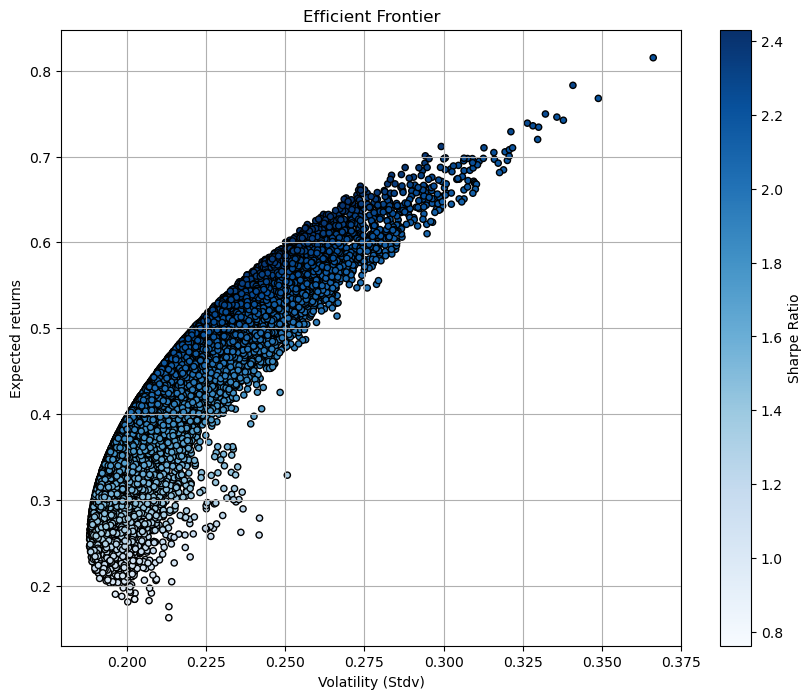

In [128]:
portfolio_df.plot.scatter(x = 'Volatility', y = 'Returns', c='Sharpe Ratio',
cmap = 'Blues', edgecolors = 'black', figsize = (10,8), grid=True)

plt.xlabel('Volatility (Stdv)')
plt.ylabel('Expected returns')
plt.title('Efficient Frontier')
plt.show()

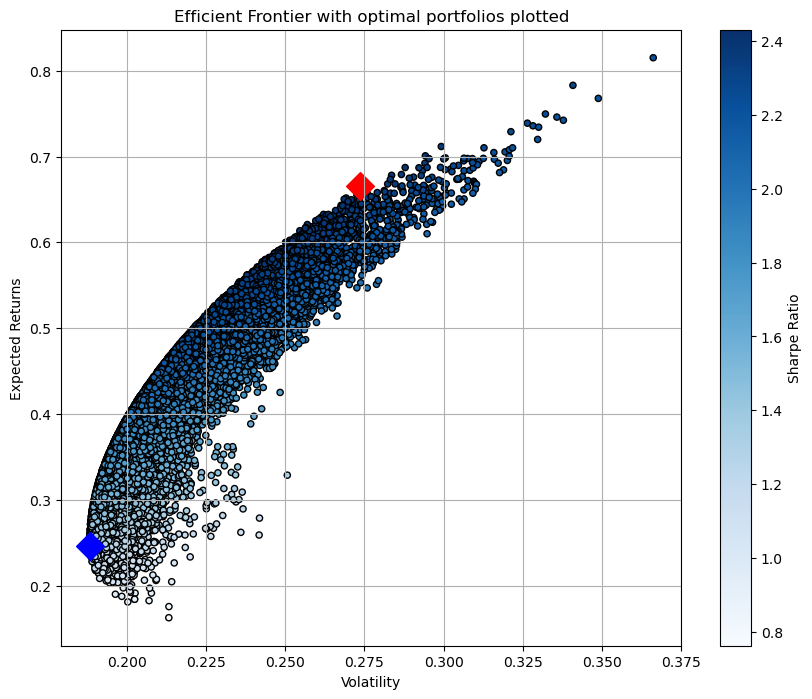

In [129]:
# Calculate min volatility and max Sharpe ratios
min_volatility = portfolio_df['Volatility'].min()
max_sharpe_ratio = portfolio_df['Sharpe Ratio'].max()

# Generate the sharpe portfolio and portfolio with min variance
sharpe_portfolio = portfolio_df.loc[portfolio_df['Sharpe Ratio'] == max_sharpe_ratio]
min_var_portfolio = portfolio_df.loc[portfolio_df['Volatility'] == min_volatility]

# Plot both portfolios on the frontier
portfolio_df.plot.scatter(x = 'Volatility', y = 'Returns', c = "Sharpe Ratio", cmap = 'Blues', edgecolors = 'black', figsize = (10,8), grid=True)
plt.scatter(x = sharpe_portfolio['Volatility'], y = sharpe_portfolio['Returns'], c = 'red', marker='D', s=200)
plt.scatter(x = min_var_portfolio['Volatility'], y = min_var_portfolio['Returns'], c = 'blue', marker='D', s=200)
plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.title("Efficient Frontier with optimal portfolios plotted")
plt.show()